The top hald of the notebook is kmeans = 5. Showing what mispredicted clusters are for records in each block cluster.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [8]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
census_enum_seq.apply_similarity(sim_columns=similar_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 24272.0


In [9]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration


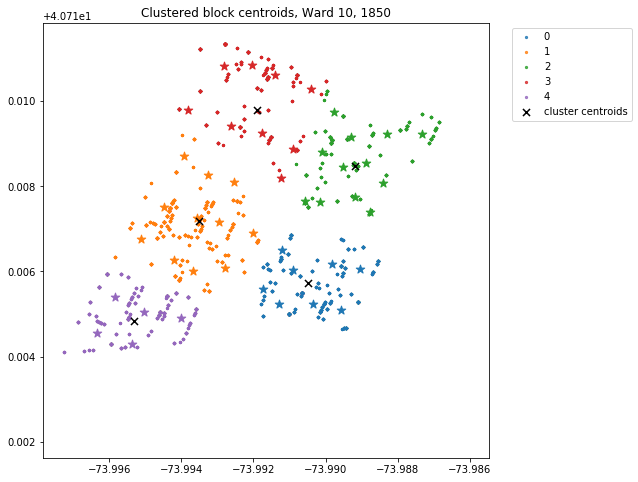

In [10]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [11]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.9766334429257721
Test score: [0.6351590106007067, 0.5553809897879026, 0.5611164581328201, 0.5577933450087565, 0.6971894832275612, 0.6017857142857143, 0.6227495908346972, 0.5254629629629629, 0.599047619047619, 0.5994983277591973]
avg Test score: 0.5955183501647938


### Refit the model using this setting (no CV) [CV score of the model is 0.60]

The results from here are used for further analysis.

In [24]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [25]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.9783024888321634
Test score: 0.6351590106007067


In [27]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [52]:
def plot_predictions(cluster_of_centroid, ward, cluster, test_df, title=None):
    #colors = [color for color, i in zip(mcolors.CSS4_COLORS.values(), range(len(np.unique(self.clusters)))) if i < len(np.unique(self.clusters))]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(np.unique(cluster_of_centroid)))]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color = colors[0]

    # for cluster, color in zip(np.unique(cluster_of_centroid), colors):
        # get cluster data
    X_subset = test_df[test_df["pred_cluster"] == cluster]
    centroids_subset = np.array(list(block_centroids[ward].values()))[cluster_of_centroid == cluster]

    # graph info
    ax.scatter(x=test_df.loc[:, x_col], y=test_df.loc[:, y_col], s=1, alpha=0.8,
               color='grey')
    for clus, co in zip(np.unique(cluster_of_centroid), colors):
        if clus == cluster:
            size = 50
        else:
            size = 20
        X_subset_2 = X_subset[X_subset["cluster"] == clus]
        ax.scatter(x=X_subset_2.loc[:, x_col], y=X_subset_2.loc[:, y_col], s=size, alpha=0.8, label=str(clus),
                   color=co)
    #     ax.scatter(centroids_subset[:, 0], centroids_subset[:, 1], marker="*", s=80, color=co)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title("Clustered block centroids, Ward {}, 1850".format(ward))

    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    plt.show()

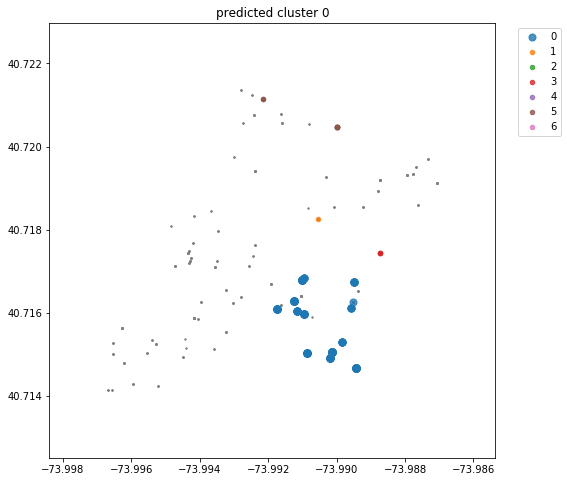

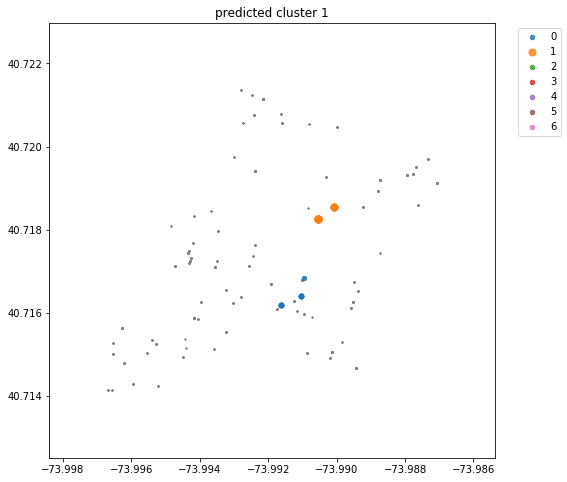

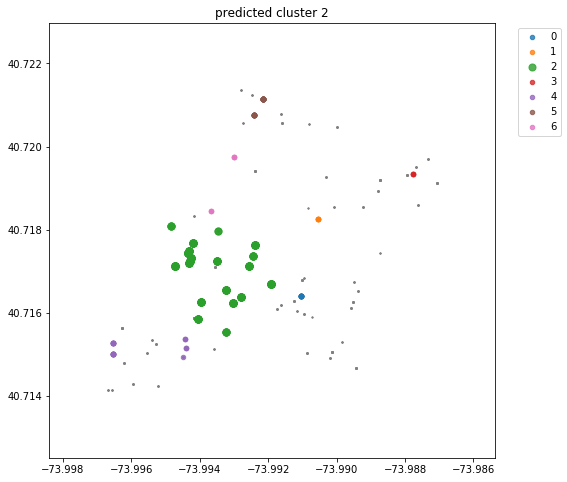

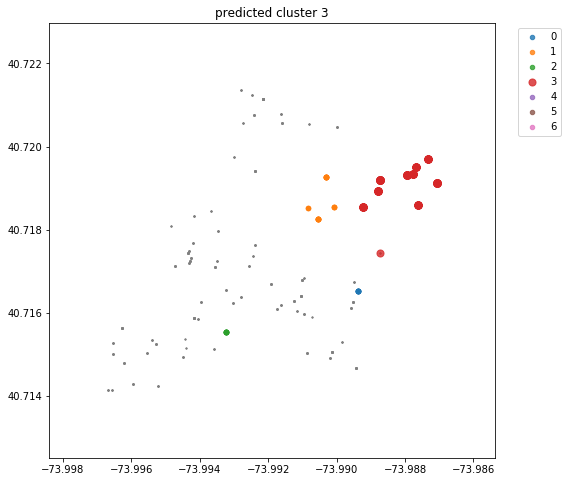

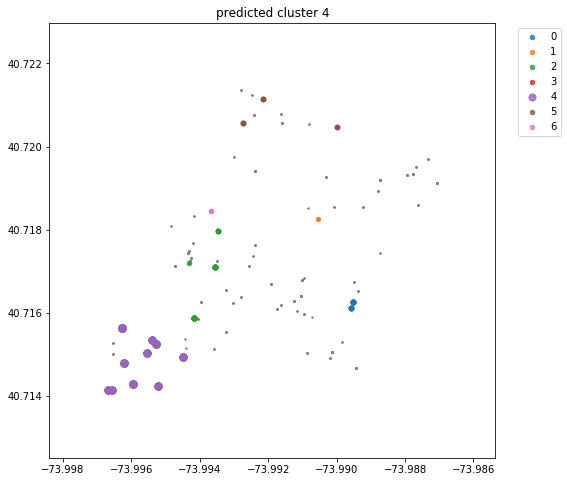

In [83]:
# if self.clusters is None:
#     raise AttributeError("Please run apply clustering first")

cluster_of_centroid = interpolate_sequences.clusters.copy()
ward = 10
cluster = 0
test_df = test


for c in range(5):
    title = 'predicted cluster ' + str(c)
    plot_predictions(cluster_of_centroid, ward, c, test_df, title)

The plot shows all records that are predicted as C cluster. For instance, `predicted cluster 0` plot shows all census records that the model predicts as in cluster 0. The biggest marks are correct prediction. The smaller ones are mispredictions and the grey ones are other Census records that are present in the test data.
* Most records are mispredicted into neightboring block clusters. 

In [55]:
test['cluster'].value_counts().sort_index()

0    253
1    285
2    244
3    212
4    138
Name: cluster, dtype: int64

In [72]:
c1 = test.groupby(['cluster', 'pred_cluster'], as_index=False)['CENSUS_SERIALB'].agg('count')
ctotal = test.groupby('cluster', as_index=False)['CENSUS_SERIALB'].agg('count')

c_per = c1.merge(ctotal, how='left', on='cluster')
c_per['percent'] = c_per['CENSUS_SERIALB_x']/c_per['CENSUS_SERIALB_y']*100
c_per.drop(columns=['CENSUS_SERIALB_x', 'CENSUS_SERIALB_y'])
pd.pivot_table(c_per, values='percent', index='cluster',
                    columns=['pred_cluster'], fill_value=0)

pred_cluster,0,1,2,3,4
cluster,,,,,
0,66.007905,7.905138,18.972332,1.185771,5.928854
1,5.263158,74.385965,8.771930,3.859649,7.719298
2,20.901639,0.000000,61.885246,0.409836,16.803279
3,0.000000,19.811321,24.528302,54.716981,0.943396
4,0.724638,31.159420,2.898551,12.318841,52.898551


In each `true_block_cluster`, there are some `pred_block_cluster` that never appear. Most are block clusters that are further from the true block cluster. Would it predict better if there are more block clusters so that there are more clusters not adjacent to the true cluster?

## Try with kmeans=7

There should be around 6-7 blocks in a cluster (as opposed to 7-9 when kmeans=5)

n is 7 and it's the 10th iteration
n is 7 and it's the 20th iteration
n is 7 and it's the 30th iteration
n is 7 and it's the 40th iteration
n is 7 and it's the 50th iteration


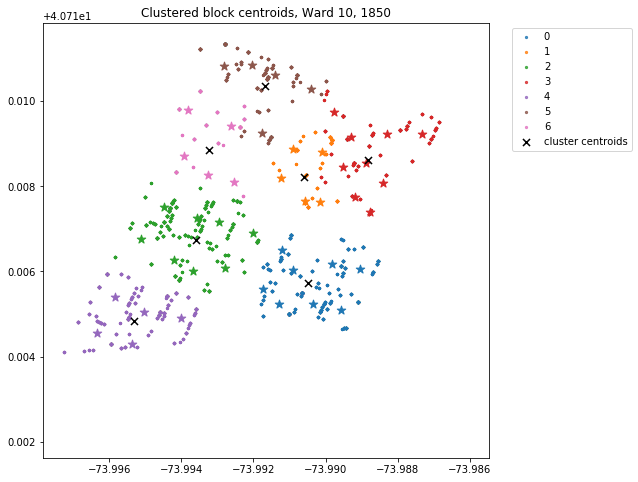

In [73]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(7), block_centroids)
score, model = interpolate_sequences.kmeans_best(7)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [74]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.9767256026841826
Test score: [0.7056603773584905, 0.5727986050566696, 0.5265273311897106, 0.5659536541889483, 0.5320945945945946, 0.579734219269103, 0.6012058570198106, 0.6328257191201354, 0.6631578947368421, 0.521505376344086]
avg Test score: 0.590146362887839


### Refit the model using this setting (no CV) [CV score of the model is 0.60]

The results from here are used for further analysis.

In [75]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [76]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.9702493190865283
Test score: 0.7056603773584905


In [77]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [81]:
interpolate_sequences.clusters

array([4, 4, 4, 2, 0, 0, 0, 2, 2, 6, 1, 0, 3, 3, 5, 6, 5, 5, 3, 3, 4, 4,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 6, 6, 1, 1, 3, 3, 3, 1, 1, 6, 5, 5, 3,
       3], dtype=int32)

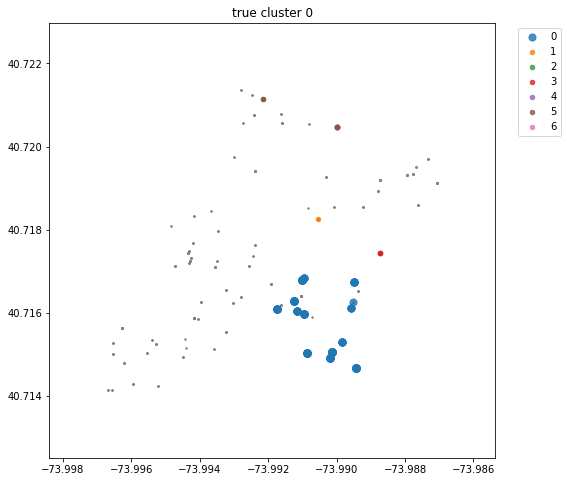

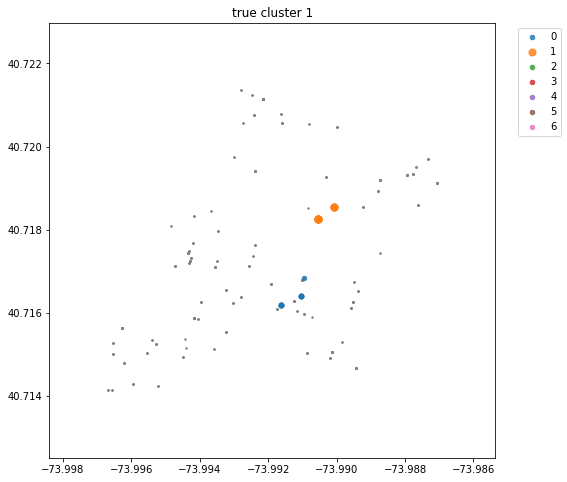

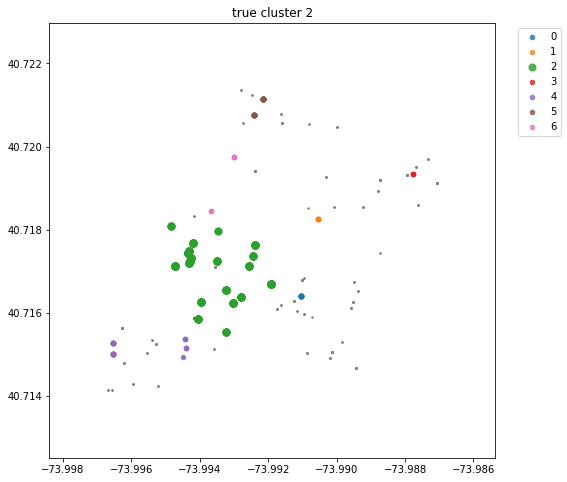

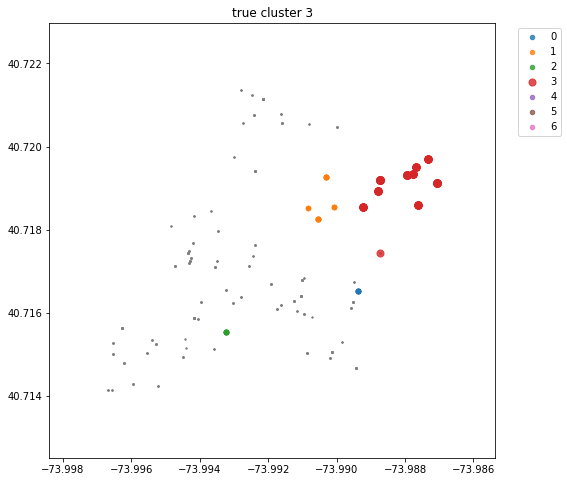

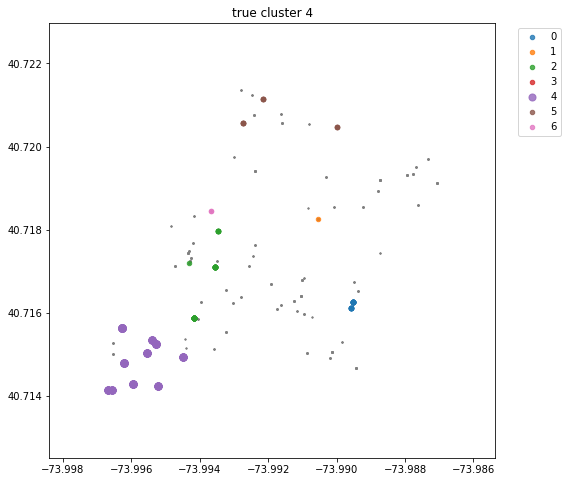

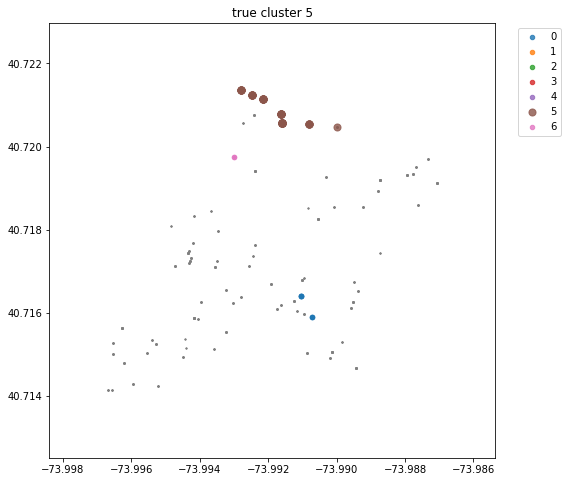

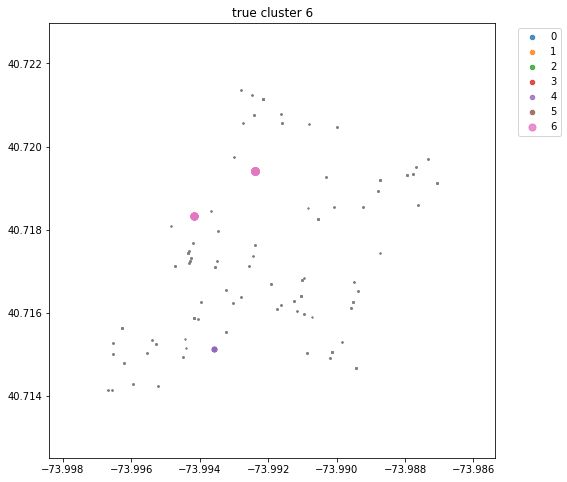

In [82]:
# if self.clusters is None:
#     raise AttributeError("Please run apply clustering first")

cluster_of_centroid = interpolate_sequences.clusters.copy()
ward = 10
cluster = 0
test_df = test


for c in range(7):
    title = 'true cluster ' + str(c)
    plot_predictions(cluster_of_centroid, ward, c, test_df, title)

The plot shows all records that are predicted as C cluster. For instance, `predicted cluster 0` plot shows all census records that the model predicts as in cluster 0. The biggest marks are correct prediction. The smaller ones are mispredictions and the grey ones are other Census records that are present in the test data.


In [79]:
test['cluster'].value_counts().sort_index()

0    253
1     47
2    289
3    153
4    155
5    120
6     43
Name: cluster, dtype: int64

In [80]:
c1 = test.groupby(['cluster', 'pred_cluster'], as_index=False)['CENSUS_SERIALB'].agg('count')
ctotal = test.groupby('cluster', as_index=False)['CENSUS_SERIALB'].agg('count')

c_per = c1.merge(ctotal, how='left', on='cluster')
c_per['percent'] = c_per['CENSUS_SERIALB_x']/c_per['CENSUS_SERIALB_y']*100
c_per.drop(columns=['CENSUS_SERIALB_x', 'CENSUS_SERIALB_y'])
pd.pivot_table(c_per, values='percent', index='cluster',
                    columns=['pred_cluster'], fill_value=0)

pred_cluster,0,1,2,3,4,5,6
cluster,,,,,,,
0,67.588933,7.905138,5.533597,4.347826,11.462451,3.162055,0.000000
1,2.127660,19.148936,12.765957,63.829787,2.127660,0.000000,0.000000
2,0.000000,0.000000,75.086505,3.806228,21.107266,0.000000,0.000000
3,1.960784,0.000000,2.614379,95.424837,0.000000,0.000000,0.000000
4,0.000000,0.000000,18.709677,0.000000,76.774194,0.000000,4.516129
5,7.500000,0.000000,35.000000,0.000000,12.500000,45.000000,0.000000
6,0.000000,0.000000,16.279070,0.000000,4.651163,4.651163,74.418605


## How similary are two records that are correctly and wrongly predicted?